In [3]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.utils import shuffle # shuffle can shffule two array with the same random seed to maintain the mapping relation
import torch.utils.data as Data
import scipy.io as sio

import numpy as np
import scipy.signal as signal
from scipy.signal import firwin, lfilter 

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

In [23]:
def get_8080_one_line_current_data_with_label_from_keyword(keyword,label):
    
    filelist = []
    for root,_,fileL in os.walk("raw_data"):
        for eachfile in fileL:
            if eachfile.endswith(".csv") and (eachfile.startswith(str(label)) or eachfile.count(keyword)):
                filelist.append(os.path.join(root,eachfile))
    rdata = np.array([0 for i in range(6400)])
    rdata = np.hstack((-1,rdata))
    output_file = "processed_data\\" + keyword + "_pixelvalue.csv"
    for eachfile in filelist:
        
        print(f"getting data from file {eachfile}")
        df = pd.read_csv(eachfile)
        df = df.values[:,1:]
        for cid in range(1,df.shape[1]):
            data = df[:,cid]
            length = data.shape[0]
            for startid in range(0,length-6400,6400):
                tem = np.hstack((label,data[startid:startid+6400])).reshape(1,6401)
                pd.DataFrame(tem).to_csv(output_file, mode="a", header=False, index=False)
           

In [24]:
def load_mat_to_two_current_filtered(matpath):
    # 格式化读取.mat文件，返回两相电流的数据
    # if not matname.endswith('.mat'):
    #     matnamewithmat = matname[:] + '.mat'
    # else:
    #     matnamewithmat = matname[:]
    #     matname = matname[:-4]
    if(matpath.find('\\')):
        matname = os.path.basename(matpath)[:-4]
    print(matname,matpath)
    # 加载 .mat 文件
    data = sio.loadmat(matpath)
    data = data[matname]
    data = data['Y']
    data = data[0][0][0]
    
    cdata1 = data[1][2].reshape(-1)
    cdata2 = data[2][2].reshape(-1)
    
    fs = 64000  # 采样率
    fc = 25000  # 截止频率
    order = 2  # 滤波器阶数 不知有无影响？
    b, a = signal.butter(order, fc/(fs/2), 'lowpass')

    cdata1 = signal.filtfilt(b,a,cdata1)
    cdata2 = signal.filtfilt(b,a,cdata2)
    cdata = np.vstack((cdata1,cdata2))
    return cdata


In [25]:
def get_fft_from_tdsignal(time_domain_signal,sampling_rate=64000):

    # 设置参数
    data_length = len(time_domain_signal)  # 数据长度    
    # window_function = np.hanning(data_length)  # 窗口函数

    # 进行 FFT
    frequency_domain_signal = fft(time_domain_signal,data_length)
   
    index = np.argmax(frequency_domain_signal, axis = 0)
   
    # 计算频率
    frequencies = np.fft.fftfreq(data_length, d=1/sampling_rate)
    
    
    # print(frequencies.shape,frequency_domain_signal.shape)
    # 绘制频谱图
    frequency_domain_signal = np.abs(frequency_domain_signal)
    frequency_domain_signal = frequency_domain_signal/data_length
    frequency_domain_signal = 20 * np.log10(frequency_domain_signal)

    index = np.argmax(frequency_domain_signal, axis = 0)
    
    # print(frequencies[index])

    # greatest_fre = max(2,frequencies[index])

    # filtered_data = band_stop_filter(time_domain_signal,fs,[greatest_fre - 2, greatest_fre + 2], order = 2)

    # 设置 x 轴范围
    return frequency_domain_signal[:2500]
    


In [26]:
def get_data_and_convert_to_pixels(keyword, label, step, td_length = 6400, fft_length = 64000, data_dir="raw_data", output_dir="processed_data"):
    """
    获取指定关键词和标签的数据，并转换为像素值。

    Args:
        keyword (str): 关键词。
        label (str): 标签。
        step (int): 步长。
        data_dir (str, optional): 数据目录。 Defaults to "raw_data".
        output_dir (str, optional): 输出目录。 Defaults to "processed_data".
    """

    output_file = os.path.join(output_dir, f"{keyword}_pixelvalue.csv")

    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".csv") and (file.startswith(str(label)) or keyword in file):
                file_path = os.path.join(root, file)
                print(f"Getting data from file {file_path}")

                df = pd.read_csv(file_path)
                data = df.values[:, 1:]
                for cid in range(1, data.shape[1]):
                    current_data = data[:, cid]
                    length = current_data.shape[0]

                    for start_id in range(0, length - 6400, step):
                        data_segment = current_data[start_id:start_id + 6400]
                        normalized_data = (data_segment - min(data_segment)) / (max(data_segment) - min(data_segment)) * 255
                        pixel_data = np.hstack((label, normalized_data))
                        pixel_data = pixel_data.reshape(1, 6401)

                        pd.DataFrame(pixel_data).to_csv(output_file, mode="a", header=False, index=False)

            elif file.endswith(".mat") and (keyword in file):
                file_path = os.path.join(root, file)
                data = load_mat_to_two_current_filtered(file_path)
                for cid in range(data.shape[0]):
                    current_data = data[cid, :]
                    length = current_data.shape[0]

                    for end_id in range(fft_length, length, step): 
                        data_segment = current_data[end_id - step :end_id].copy()
                        fft_data = get_fft_from_tdsignal(current_data[end_id - fft_length :end_id])

                        normalized_data = (data_segment - min(data_segment)) / (max(data_segment) - min(data_segment)) * 255
                        pixel_data = np.hstack((label, normalized_data,fft_data))
                        pixel_data = pixel_data.reshape(1, -1)

                        temfile = output_file[:-4] + ".csv"
                        pd.DataFrame(pixel_data).to_csv(temfile, mode="a", header=False, index=False)
                    

In [27]:
def load_data_and_convert_to_grid(datadicts, ratio, data_dir="processed_data", length=6401):
    """
    加载数据并转换为网格。

    Args:
        datadicts (dict): 数据字典。
        ratio: float, train:test占比
        data_dir (str, optional): 数据目录。 Defaults to "processed_data".
        length: 一个 数据样本大小：包含时域频域以及标签
    Returns:
        tuple: 训练集和验证集。
    """
    # print('here')
    total_train_set = np.zeros(length)
    total_val_set = np.zeros(length)

    for keyword, file in datadicts.items():
        file_path = os.path.join(data_dir, f"{keyword}_pixelvalue.csv")
        print(f"Getting data with keyword {keyword}")

        df = pd.read_csv(file_path, header=None)
        data = df.values

        np.random.shuffle(data)
        sub_train_set, sub_val_set = data[:int(ratio * len(data))], data[int(ratio * len(data)):]

        total_train_set = np.vstack((total_train_set, sub_train_set.copy()))
        total_val_set = np.vstack((total_val_set, sub_val_set.copy()))

    
    total_train_set = total_train_set[1:]
    total_val_set = total_val_set[1:]
    # np.random.shuffle(total_set)
    # train_set, val_set = total_set[:int(ratio * len(total_set))], total_set[int(ratio * len(total_set)):]

    train_y = total_train_set[:, 0]
    train_x = total_train_set[:, 1:]
    val_y = total_val_set[:, 0]
    val_x = total_val_set[:, 1:]

    print(train_y.shape, train_x.shape)
    print(val_y.shape, val_x.shape)

    return train_x, train_y, val_x, val_y

In [ ]:
get_data_and_convert_to_pixels("KA04",1,6400,6400,128000,output_dir="G_lp_td_fd_pixel")

In [29]:
x1,y1,x2,y2 = load_data_and_convert_to_grid({"K004":1},0.9,"G_lp_td_fd_pixel",6401+2500)

Getting data with keyword K001
(3015,) (3015, 8900)
(335,) (335, 8900)


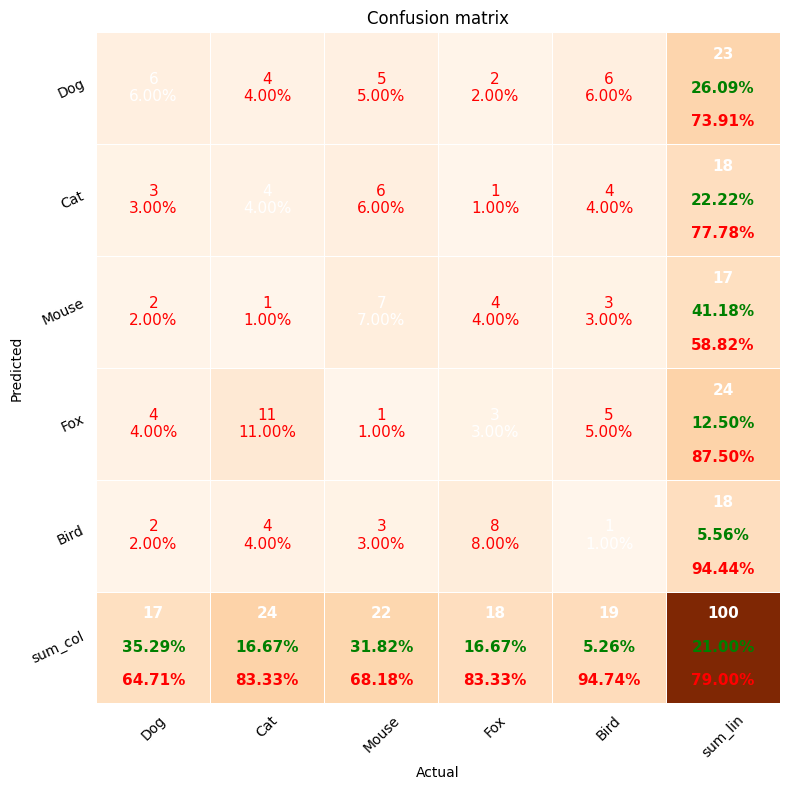

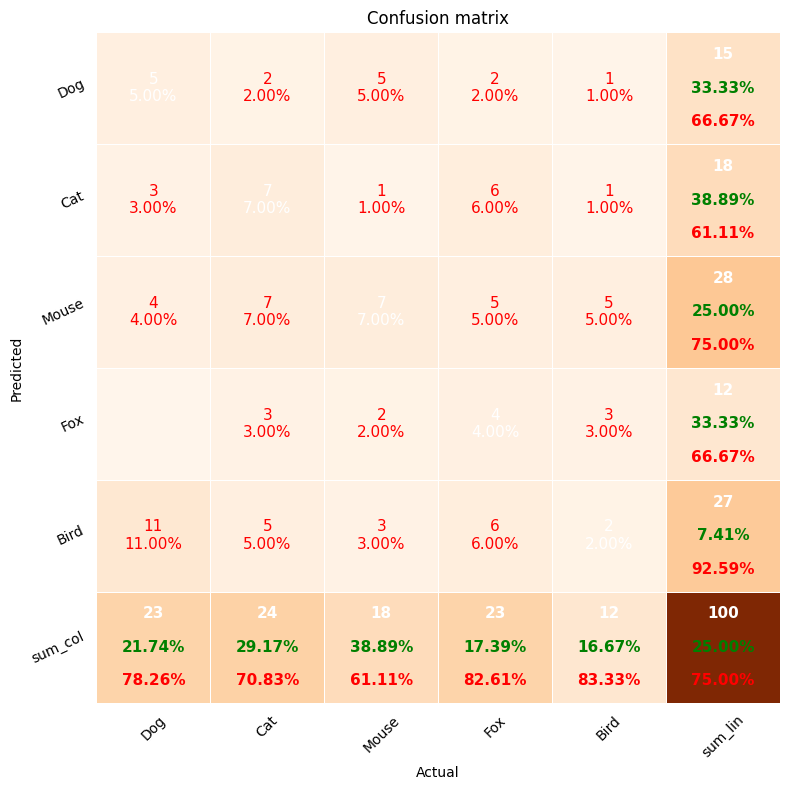

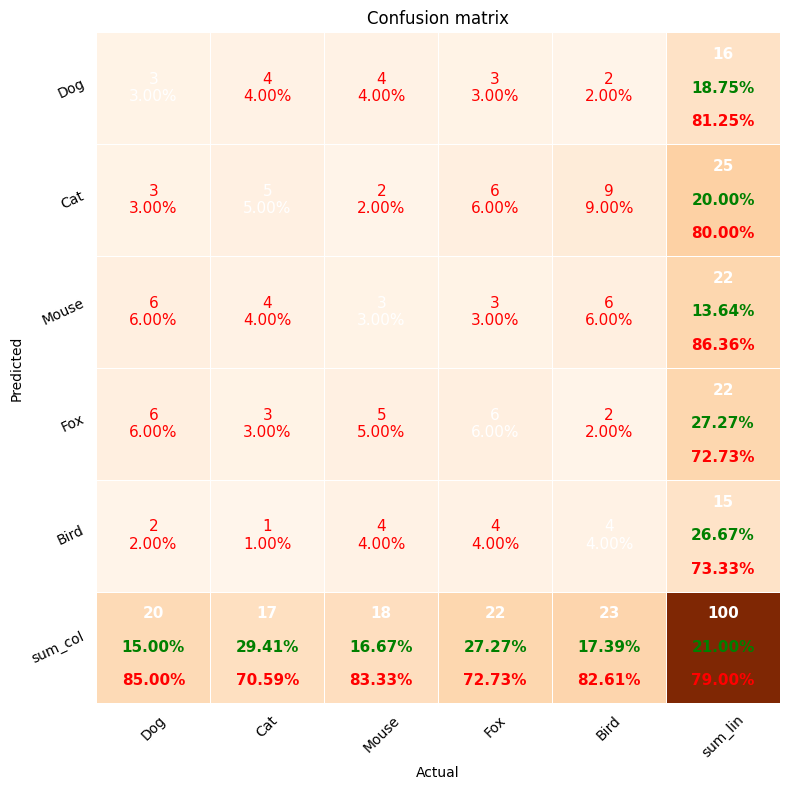

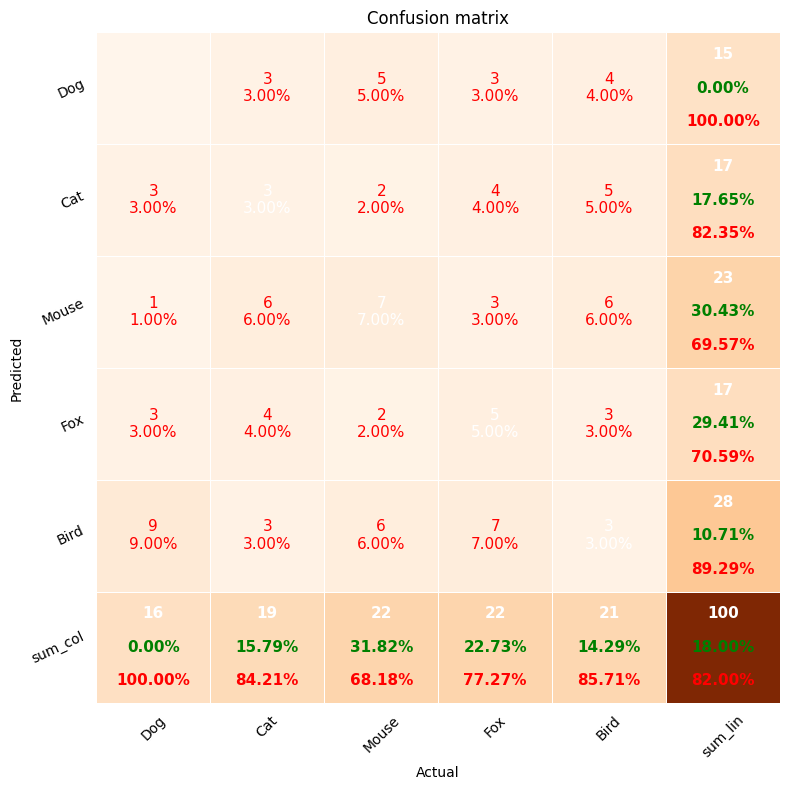

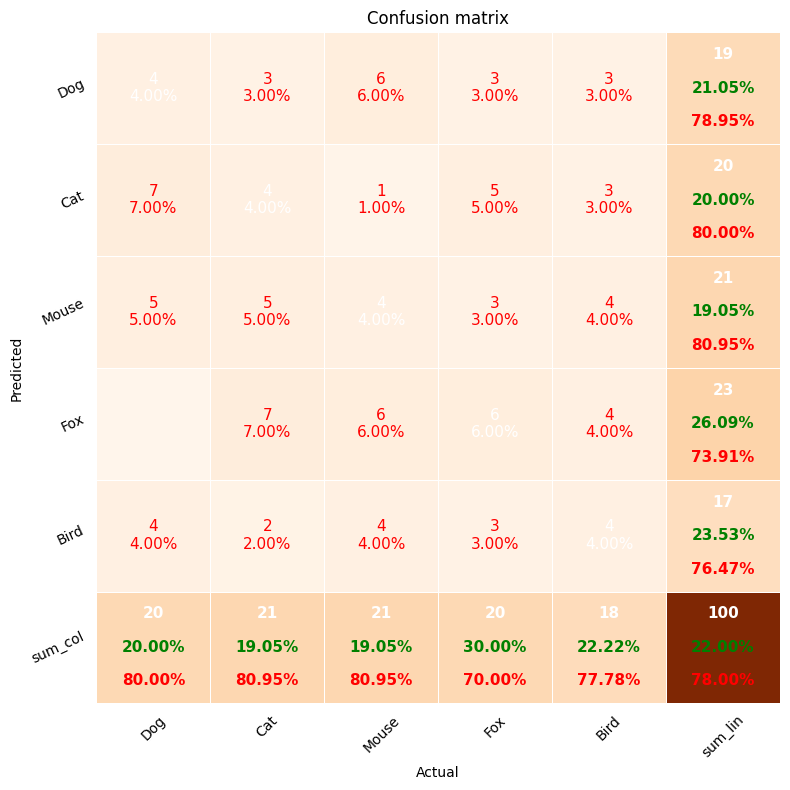

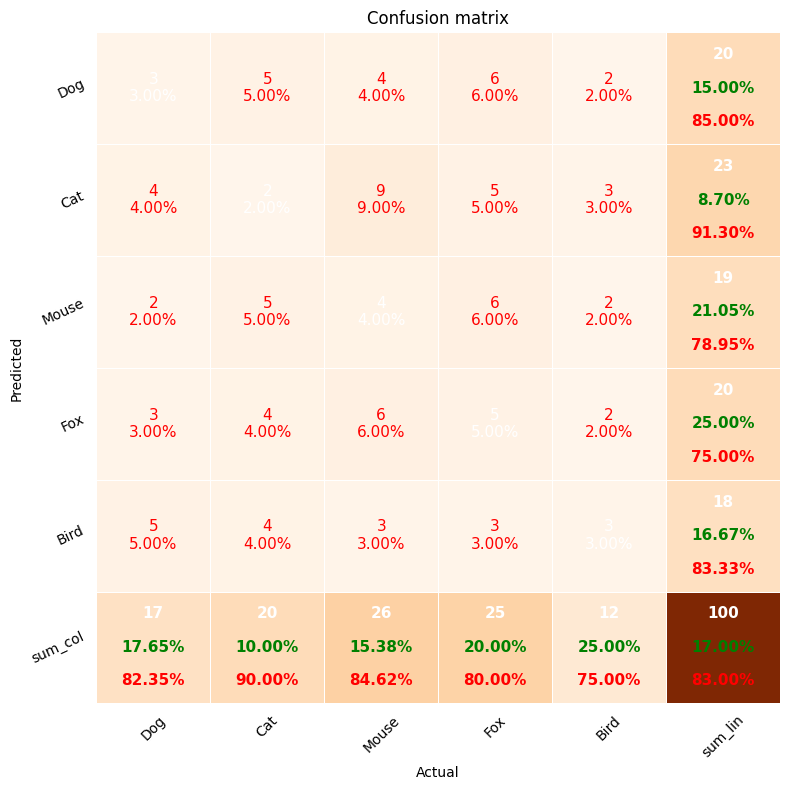

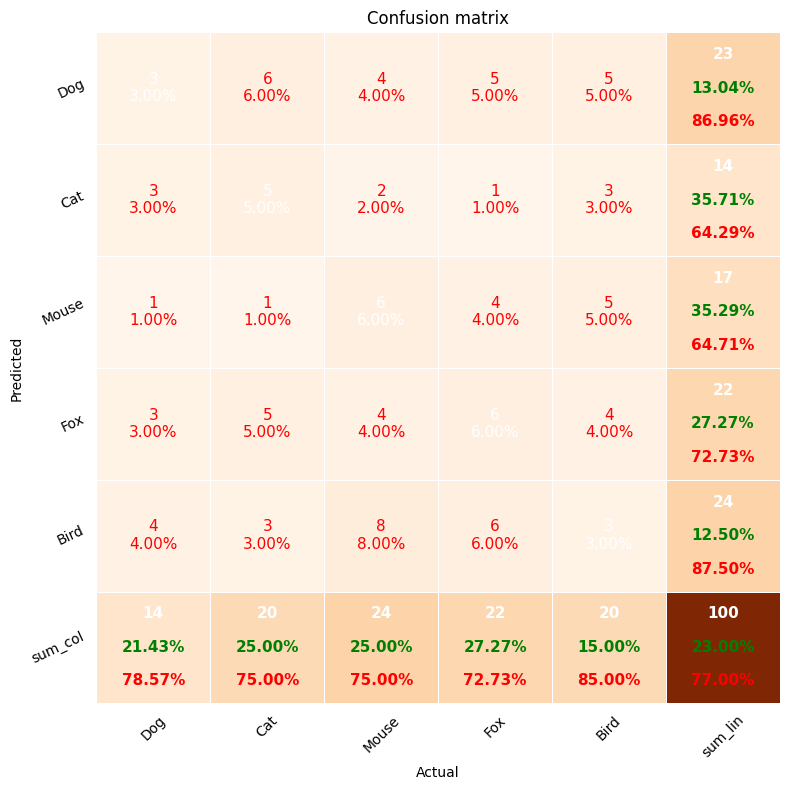

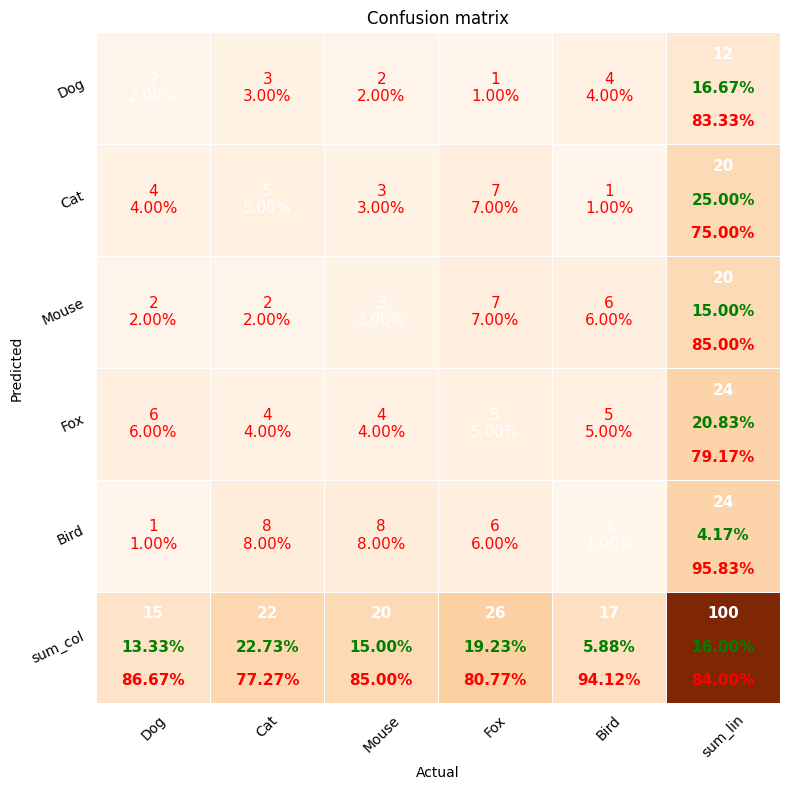

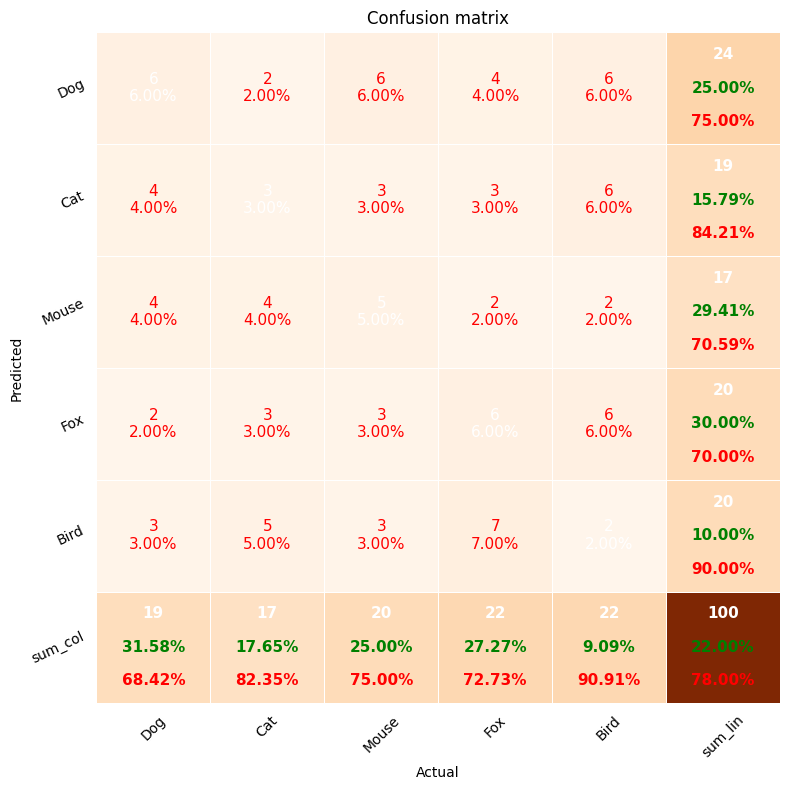

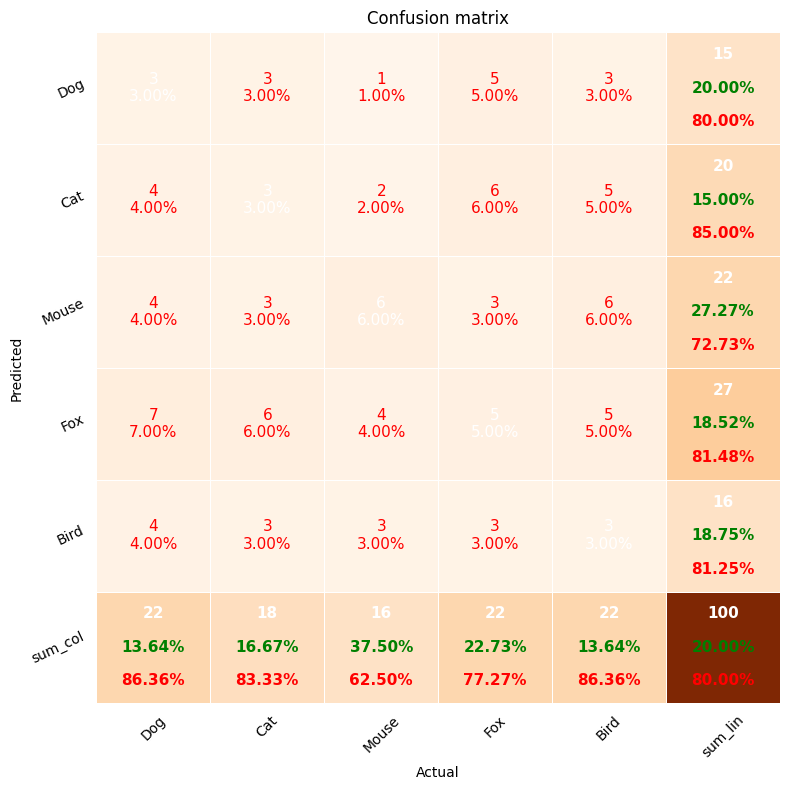

In [2]:
import numpy as np
from pretty_confusion_matrix import pp_matrix_from_data
import random as r
import time
for i in range(10):
    columns = ['Dog', 'Cat', 'Mouse', 'Fox', 'Bird'] 
    
    # y_test = np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
    #                 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5])
    # predic = np.array([1, 2, 4, 3, 5, 1, 2, 4, 3, 5, 1, 2, 3, 4, 4, 1, 4, 3, 4, 5, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 3, 3, 5, 1, 2, 3, 3, 5, 1, 2,
    #                 3, 4, 4, 1, 2, 3, 4, 1, 1, 2, 3, 4, 1, 1, 2, 3, 4, 1, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 4, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5])
    y_test = np.array([r.randint(0,4) for i in range(100)])

    predic = np.array([r.randint(0,4) for i in range(100)])
    time.sleep(1)
    pp_matrix_from_data(y_test, predic, columns)

In [ ]:


def band_stop_filter(data, fs, f_range, order):
    nyquist = 0.5 * fs
    low = f_range[0] / nyquist
    high = f_range[1] / nyquist
    b, a = signal.butter(order, [low, high], btype='bandstop',  analog=False)
    filtered_data = signal.lfilter(b, a, data)
    return filtered_data

def plot_one(data):

    time_domain_signal = data.reshape(-1)
    # plt.plot(time_domain_signal)
    print(time_domain_signal.shape)

    # 设置参数
    data_length = len(time_domain_signal)  # 数据长度
    sampling_rate = 64000  # 采样率
    # window_function = np.hanning(data_length)  # 窗口函数

    # 进行 FFT
    frequency_domain_signal = fft(time_domain_signal,data_length)
   
    index = np.argmax(frequency_domain_signal, axis = 0)
   
    # 计算频率
    frequencies = np.fft.fftfreq(data_length, d=1/sampling_rate,)
    
    
    # print(frequencies.shape,frequency_domain_signal.shape)
    # 绘制频谱图
    frequency_domain_signal = np.abs(frequency_domain_signal)
    frequency_domain_signal = frequency_domain_signal/data_length
    frequency_domain_signal = 20 * np.log10(frequency_domain_signal)

    index = np.argmax(frequency_domain_signal, axis = 0)
    
    print(frequencies[index])

    greatest_fre = max(2,frequencies[index])
    
    plt.figure(1,figsize=(16,4))
    plt.plot(time_domain_signal)
    fs = 64000
    filtered_data = band_stop_filter(time_domain_signal,fs,[greatest_fre - 2, greatest_fre + 2], order = 2)
    plt.figure(2,figsize=(16,4))
    plt.plot(filtered_data)
    fft_data = np.fft.fft(filtered_data)
    freq = np.fft.fftfreq(len(filtered_data), 1/fs)

    fft_data = 20 * np.log10(fft_data)
    plt.figure(3,figsize=(16,4))
    plt.plot(freq,fft_data)
    
    plt.xlim(0,500)
    plt.figure(4,figsize=(16,4))
    plt.plot(frequencies, frequency_domain_signal)
    print(frequency_domain_signal)
    # pd.DataFrame(frequency_domain_signal).to_csv('tem.csv', mode="a", header=False, index=False)
    # print(frequencies)
    # 设置 x 轴范围
    # 设置 x 轴范围
    plt.xlim(0, 500)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")

    plt.figure(5,figsize=(16,4))
    plt.plot(frequency_domain_signal[:1000])



# plot_one(good[0:6400])
plot_one(good[0:128000])

In [31]:
# 降采样示例


good = load_mat_to_two_current_filtered(R"raw_data\K001\K001\N09_M07_F10_K001_1.mat")
good = good[0,:]
bad = load_mat_to_two_current_filtered(R"raw_data\KA04\KA04\N09_M07_F10_KA04_1.mat")
bad = bad[0,:]


plt.plot(tem)

import numpy as np
from scipy.interpolate import interp1d

# 原始信号以64000Hz采样频率
original_sample_rate = 1500
# 目标采样频率
target_sample_rate = 900
# 信号序列长度
signal_length = len(tem)


# 生成原始时间序列
original_time = np.arange(signal_length) / original_sample_rate
# plt.figure(2)
# plt.plot(original_time)
# 生成目标时间序列
target_time = np.arange(0, original_time[-1], 1 / target_sample_rate)
# plt.figure(3)
# plt.plot(target_time)
# 使用线性插值进行插值
interp_func = interp1d(original_time, tem, kind='linear', fill_value='extrapolate')
interpolated_signal = interp_func(target_time)
plt.figure(4,figsize=(20,4))
plt.plot(interpolated_signal)
plt.plot(tem2)
# interpolated_signal 就是以20000Hz采样频率进行采样的信号序列


(8900,)


In [8]:
def get_grid_current_data_with_label_from_keyword(keyword,label=0):
    
    filelist = []
    for root,_,fileL in os.walk("raw_data"):
        for eachfile in fileL:
            if eachfile.endswith(".csv") and (eachfile.startswith(str(label)) or eachfile.count(keyword)):
                filelist.append(os.path.join(root,eachfile))
    # rdata = np.array([0 for i in range(6400)])
    # rdata = np.hstack((-1,rdata))
    # output_file = "processed_data\\" + keyword + "_pixelvalue.csv"
    for eachfile in filelist:
        
        print(f"getting data from file {eachfile}")
        df = pd.read_csv(eachfile)
        df = df.values[:,1:]
        return df
